In [10]:
# imodels imports
from imodels import get_clean_dataset
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier, RandomForestPlusRegressor
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusMDI

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, root_mean_squared_error

# other important libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# pca stuff
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# genotype = pd.read_csv("/scratch/users/omer_ronen/mutemb_esm/X_k_5_ilvm_oh.csv")
genotype = pd.read_csv("/scratch/users/omer_ronen/mutemb_esm/X_k_5_ilvm_esm_prod_pppl_full_ptv.csv")
phenotype = pd.read_csv('/scratch/users/omer_ronen/mutemb_esm/y_ilvm_oh.csv')
# make genotype a numpy array
genotype = genotype.to_numpy()
# get last twelve features in genotype
limited_genotype = genotype[:,-12:]
# make phenotype a 1D numpy array
phenotype = phenotype.to_numpy().reshape(-1)

In [12]:
scaler = StandardScaler()
genotype_scaled = scaler.fit_transform(genotype)

# Step 2: Perform PCA
pca = PCA(n_components=5000)  # We reduce the data to 2 principal components
genotype_pca = pca.fit_transform(genotype_scaled)

In [ ]:
# get point where explained_variance_ratio is zero
zero_variance = np.where(np.isclose(pca.explained_variance_ratio_, 0))
genotype_pca = genotype_pca[:,:zero_variance[0][0]]

(22542, 4270)

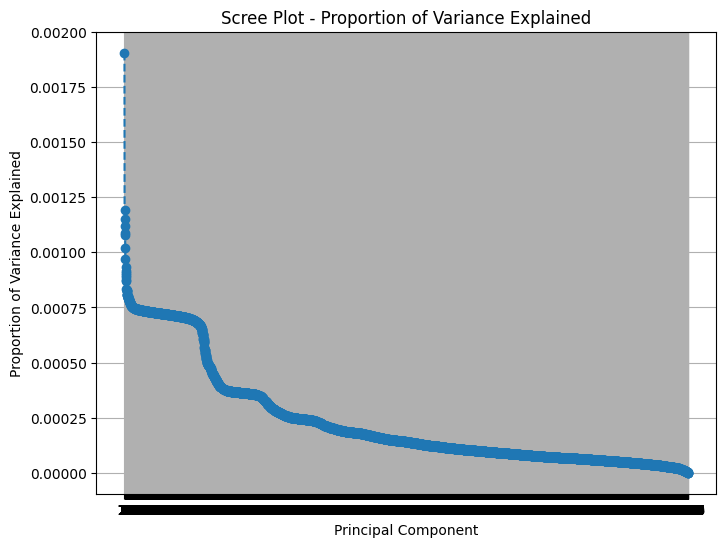

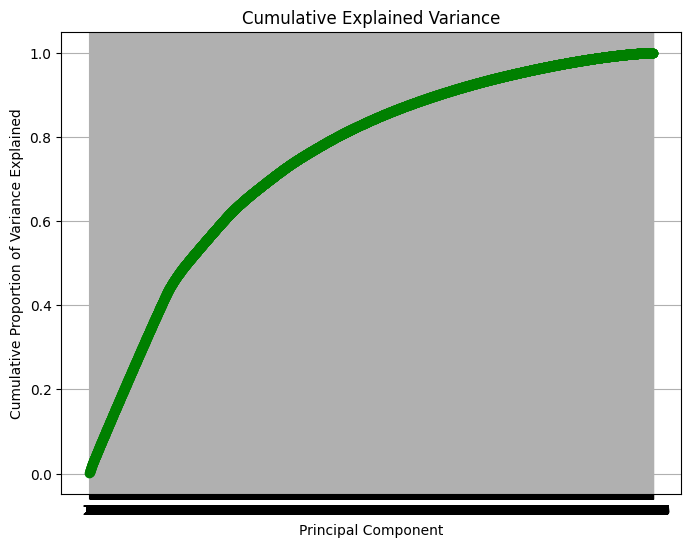

In [24]:
# Step 3: Explained Variance Ratio (Proportion of variance explained by each component)
explained_variance_ratio = pca.explained_variance_ratio_[:zero_variance[0][0]]

# Step 4: Create the Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot - Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

# Step 5: (Optional) Plot cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='green', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid(True)
plt.show()

In [25]:
cor_limited = []
cor_full = []
r2_limited = []
r2_full = []
rmse_limited = []
rmse_full = []

for i in range(1):
    # train-test split
    genotype_train, genotype_test, limited_genotype_train, \
    limited_genotype_test, phenotype_train, phenotype_test = \
        train_test_split(genotype_pca, limited_genotype, phenotype, test_size = 0.3,
                        random_state = i)
    # fit xgboost on full and limited models
    params = {
        'objective': 'reg:squarederror',  # Use 'reg:squarederror' for regression
        'max_depth': 5,
        'eta': 0.1,
        'eval_metric': 'logloss'
    }
    limited_dtrain = xgb.DMatrix(limited_genotype_train, label=phenotype_train)
    full_dtrain = xgb.DMatrix(genotype_train, label=phenotype_train)
    # train the model
    limited_model = xgb.train(params, limited_dtrain, num_boost_round=100)
    full_model = xgb.train(params, full_dtrain, num_boost_round=100)
    # predict on test set
    limited_pred = limited_model.predict(xgb.DMatrix(limited_genotype_test))
    full_pred = full_model.predict(xgb.DMatrix(genotype_test))
    # calculate correlation for pred-check
    cor_full.append(np.corrcoef(phenotype_test, full_pred)[0,1])
    cor_limited.append(np.corrcoef(phenotype_test, limited_pred)[0,1])
    r2_full.append(r2_score(phenotype_test, full_pred))
    r2_limited.append(r2_score(phenotype_test, limited_pred))
    rmse_full.append(root_mean_squared_error(phenotype_test, full_pred))
    rmse_limited.append(root_mean_squared_error(phenotype_test, limited_pred))

cor_full = np.array(cor_full)
cor_limited = np.array(cor_limited)
r2_full = np.array(r2_full)
r2_limited = np.array(r2_limited)
rmse_full = np.array(rmse_full)
rmse_limited = np.array(rmse_limited)
# get means and sds of each
mean_cor_full = np.mean(cor_full)
mean_cor_limited = np.mean(cor_limited)
sd_cor_full = np.std(cor_full)
sd_cor_limited = np.std(cor_limited)
mean_r2_full = np.mean(r2_full)
mean_r2_limited = np.mean(r2_limited)
sd_r2_full = np.std(r2_full)
sd_r2_limited = np.std(r2_limited)
mean_rmse_full = np.mean(rmse_full)
mean_rmse_limited = np.mean(rmse_limited)
sd_rmse_full = np.std(rmse_full)
sd_rmse_limited = np.std(rmse_limited)

print("Full Model Correlation: ", mean_cor_full, " +/- ", sd_cor_full)
print("Limited Model Correlation: ", mean_cor_limited, " +/- ", sd_cor_limited)
print("Minimum Difference in Correlation: ", np.min(cor_full - cor_limited))
print("Min of Full Correlation - Max of Limited Correlation: ", np.min(cor_full) - np.max(cor_limited))

print("Full Model R2: ", mean_r2_full, " +/- ", sd_r2_full)
print("Limited Model R2: ", mean_r2_limited, " +/- ", sd_r2_limited)
print("Minimum Difference in R2: ", np.min(r2_full - r2_limited))
print("Min of Full R2 - Max of Limited R2: ", np.min(r2_full) - np.max(r2_limited))

print("Full Model RMSE: ", mean_rmse_full, " +/- ", sd_rmse_full)
print("Limited Model RMSE: ", mean_rmse_limited, " +/- ", sd_rmse_limited)
print("Minimum Difference in RMSE: ", np.min(rmse_full - rmse_limited))
print("Min of Full RMSE - Max of Limited RMSE: ", np.min(rmse_full) - np.max(rmse_limited))

Full Model Correlation:  0.507616414984057  +/-  0.0
Limited Model Correlation:  0.6205696145882396  +/-  0.0
Minimum Difference in Correlation:  -0.1129531996041826
Min of Full Correlation - Max of Limited Correlation:  -0.1129531996041826
Full Model R2:  0.25602762362888865  +/-  0.0
Limited Model R2:  0.3839563913017795  +/-  0.0
Minimum Difference in R2:  -0.12792876767289085
Min of Full R2 - Max of Limited R2:  -0.12792876767289085
Full Model RMSE:  7.346221858814532  +/-  0.0
Limited Model RMSE:  6.684845324765358  +/-  0.0
Minimum Difference in RMSE:  0.6613765340491744
Min of Full RMSE - Max of Limited RMSE:  0.6613765340491744
